# Tutorial 9 - VAE

Based on https://avandekleut.github.io/vae/ Thanks to Alexander



# Autoencoders

Autoencoders are a special kind of neural network used to perform dimensionality reduction. We can think of autoencoders as being composed of two networks, an **encoder** $e$ and a **decoder** $d$.

The encoder learns a non-linear transformation $e:X \to Z$ that projects the data from the original high-dimensional input space $X$ to a lower-dimensional **latent space** $Z$. We call $z = e(x)$ a **latent vector**. A latent vector is a low-dimensional representation of a data point that contains information about $x$. The transformation $e$ should have certain properties, like similar values of $x$ should have similar latent vectors (and dissimilar values of $x$ should have dissimilar latent vectors).

A decoder learns a non-linear transformation $d: Z \to X$ that projects the latent vectors back into the original high-dimensional input space $X$. This transformation should take the latent vector $z = e(x)$ and reconstruct the original input data $\hat{x} = d(z) = d(e(x))$.

An autoencoder is just the composition of the encoder and the decoder $f(x) = d(e(x))$. The autoencoder is trained to minimize the difference between the input $x$ and the reconstruction $\hat{x}$ using a kind of **reconstruction loss**. Because the autoencoder is trained as a whole (we say it's trained "end-to-end"), we simultaneosly optimize the encoder and the decoder.

<a href="https://drive.google.com/uc?export=view&id=1UXRiD4nj6z1HnWBWPKvv0lRXSMb6lGIr">
    <img src="https://drive.google.com/uc?export=view&id=1UXRiD4nj6z1HnWBWPKvv0lRXSMb6lGIr"
    style="width: 400px; max-width: 100%; height: auto"
    title="Click for the larger version." />
</a>

Below is an implementation of an autoencoder written in PyTorch. We apply it to the MNIST dataset.

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Below we write the `Encoder` class by sublcassing `torch.nn.Module`, which lets us define the `__init__` method storing layers as an attribute, and a `forward` method describing the forward pass of the network.

In [8]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

We do something similar for the `Decoder` class, ensuring we reshape the output.

In [9]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

FInally, we write an `Autoencoder` class that combines these two. Note that we could have easily written this entire autoencoder as a single neural network, but splitting them in two makes it conceptually clearer.

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Next, we will write some code to train the autoencoder on the MNIST dataset.

In [11]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)
    for epoch in range(epochs):
        for x, _ in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
            loss.backward()
            opt.step()
    return autoencoder

In [12]:
z_dim = 2
autoencoder = Autoencoder(z_dim).to(device) # GPU

data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data_loader, epochs=20)

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...


C:\Users\Eldar-Desktop\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!






KeyboardInterrupt: 

What should we look at once we've trained an autoencoder? I think that the following things are useful:

1. Look at the latent space. If the latent space is 2-dimensional, then we can transform a batch of inputs $x$ using the encoder and make a scatterplot of the output vectors. Since we also have access to labels for MNIST, we can colour code the outputs to see what they look like.
2. Sample the latent space to produce output. If the latent space is 2-dimensional, we can sample latent vectors $z$ from the latent space over a uniform grid and plot the decoded latent vectors on a grid.

In [ ]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [ ]:
plot_latent(autoencoder, data_loader)

The resulting latent vectors cluster similar digits together. We can also sample uniformly from the latent space and see how the decoder reconstructs inputs from arbitrary latent vectors.

In [57]:
def plot_reconstructed(autoencoder,  r0=(-5, 10), r1=(-10, 5), n=12):
    img = []
    for i, z2 in enumerate(np.linspace(r1[1],r1[0], n)):
        for j, z1 in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[z1, z2]]).to(device)
            x_hat = autoencoder.decoder(z)
            img.append(x_hat)
    
    print(img[0].shape)
    img = torch.cat(img)
    print(img.shape)
    img = torchvision.utils.make_grid(img,nrow=12).permute(1, 2, 0).cpu().detach().numpy()
    plt.imshow(img)
    print(img.shape)

In [64]:
len([2]*40)

40

In [3]:
plt.plot(np.arange(0, 50))
plt.savefig('./fig1.jpg')
plt.clf()
plt.plot(np.arange(0, 30))
plt.savefig('./fig2.jpg')
plt.clf()

<Figure size 1200x800 with 0 Axes>

torch.Size([1, 28, 28])
torch.Size([144, 1, 28, 28])
(362, 362, 3)


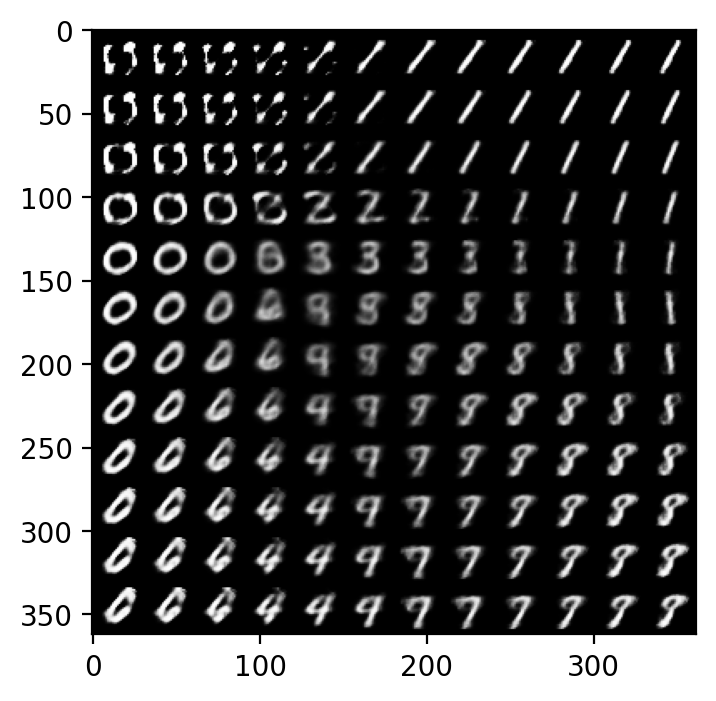

In [58]:
plot_reconstructed(autoencoder)

We intentionally plot the reconstructed latent vectors using approximately the same range of values taken on by the actual latent vectors. We can see that the reconstructed latent vectors look like digits, and the kind of digit corresponds to the location of the latent vector in the latent space. 

You may have noticed that there are "gaps" in the latent space, where data is never mapped to. This becomes a problem when we try to use autoencoders as **generative models**. The goal of generative models is to take a data set $X$ and produce more data points from the same distribution that $X$ is drawn from. For autoencoders, this means sampling latent vectors $z \sim Z$ and then decoding the latent vectors to produce images. If we sample a latent vector from a region in the latent space that was never seen by the decoder during training, the output might not make any sense at all. We see this in the top left corner of the `plot_reconstructed` output, which is empty in the latent space, and the corresponding decoded digit does not match any existing digits.

# Gaussian VAE

The only constraint on the latent vector representation for traditional autoencoders is that latent vectors should be easily decodable back into the original image. As a result, the latent space $Z$ can become disjoint and non-continuous (without probalistic structure). Variational autoencoders try to solve this problem.


$$\Large -\log p_{\theta}(x) \leq -\mathbb{E}_{z \sim q_{\phi}(z|x)} \log p_{\theta}(x|z) +  \mathbb{KL}\left( q_{\phi}(z|x) \parallel p_{\theta}(z) \right)$$
In traditional autoencoders, inputs are mapped deterministically to a latent vector $z = e(x)$. In variational autoencoders, inputs are mapped to a probability distribution over latent vectors, and a latent vector is then sampled from that distribution. The decoder becomes more robust at decoding latent vectors as a result. 

Specifically, instead of mapping the input $x$ to a latent vector $z = e(x)$, we map it instead to a mean vector $\mu(x)$ and a vector of standard deviations $\sigma(x)$. These parametrize a diagonal Gaussian distribution $\mathcal{N}(\mu, \sigma)$, from which we then sample a latent vector $z \sim \mathcal{N}(\mu, \sigma)$.

This is generally accomplished by replacing the last layer of a traditional autoencoder with two layers, each of which output $\mu(x)$ and $\sigma(x)$. An exponential activation is often added to $\sigma(x)$ to ensure the result is positive.

<a href="https://drive.google.com/uc?export=view&id=1Nl2uhtDtZAkce6Sw54EP__OV2LN2-Hk8">
    <img src="https://drive.google.com/uc?export=view&id=1Nl2uhtDtZAkce6Sw54EP__OV2LN2-Hk8"
    style="width: 400px; max-width: 100%; height: auto"
    title="Click for the larger version." />
</a>

The KL divergence between $p(z \mid x)$ and $\mathcal{N}(0, 1)$, is given by
$$
\mathbb{KL}\left( \mathcal{N}(\mu, \sigma) \parallel \mathcal{N}(0, 1) \right) = -0.5\sum \left(1+ \log \sigma^2 - \mu^2 -\sigma^2 \right)
$$

To implement this, we do not need to change the `Decoder` class. We only need to change the `Encoder` class to produce $\mu(x)$ and $\sigma(x)$, and then use these to sample a latent vector. We also use this class to keep track of the KL divergence loss term.

In [12]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.to_mean_logvar = nn.Linear(512, 2*latent_dims)
        
    def reparametrization_trick(self, mu, log_var):
        # Using reparameterization trick to sample from a gaussian
        eps = torch.randn_like(log_var)
        return mu + torch.exp(log_var / 2) * eps
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu, log_var = torch.split(self.to_mean_logvar(x),2, dim=-1)
        self.kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return self.reparametrization_trick(mu, log_var)

The autoencoder class changes a single line of code, swappig out an `Encoder` for a `VariationalEncoder`. 

In [13]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)        
        return self.decoder(z)

In order to train the variational autoencoder, we only need to add the auxillary loss in our training algorithm.

The following code is essentially copy-and-pasted from above, with a single term added added to the loss (`autoencoder.encoder.kl`).

In [14]:
def train(vae, data, epochs=20):
    opt = torch.optim.Adam(vae.parameters(), lr = 0.001)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = F.binary_cross_entropy(x_hat, x, reduction='sum') + vae.encoder.kl
            loss.backward()
            opt.step()
    return vae

In [15]:
vae = VariationalAutoencoder(z_dim).to(device) # GPU
vae = train(vae, data_loader, epochs=20)

Let's plot the latent vector representations of a few batches of data.

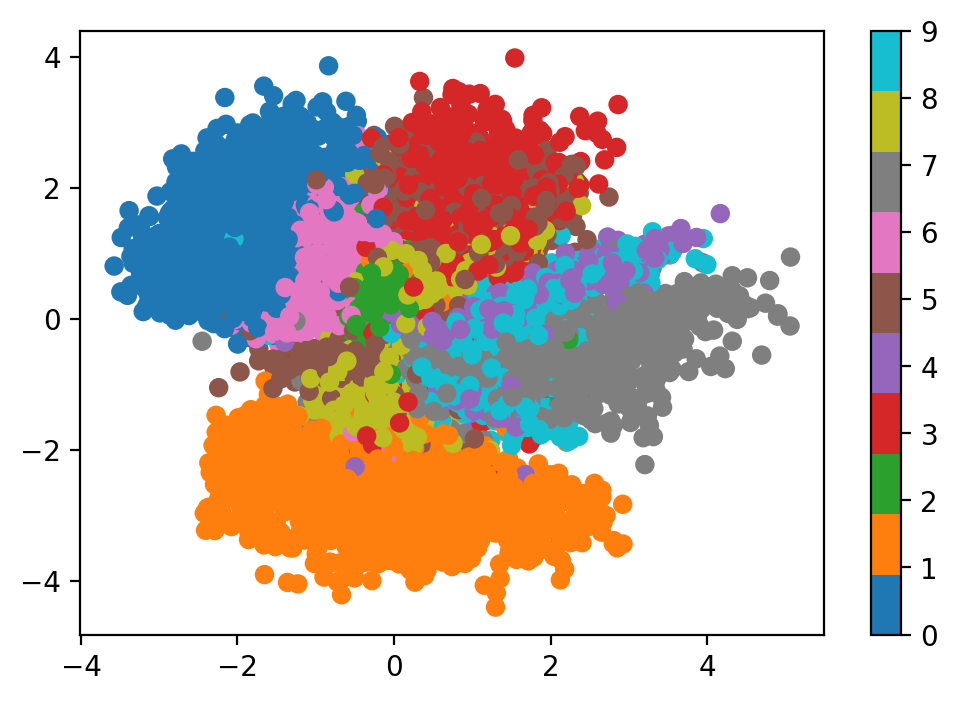

In [16]:
plot_latent(vae, data_loader)

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space:

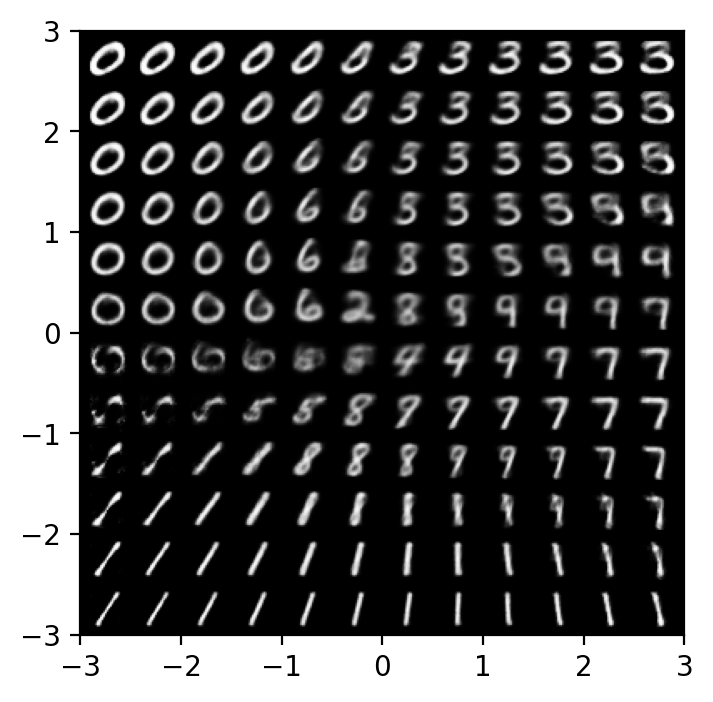

In [17]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

# Inference

One final thing that I wanted to try out was **interpolation**. Given two inputs $x_1$ and $x_2$, and their corresponding latent vectors $z_1$ and $z_2$, we can interpolate between them by decoding latent vectors between $x_1$ and $x_2$. 

The following code produces a row of images showing the interpolation between digits.

In [18]:
x, y = data_loader.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 3][1].to(device) # find a 2

In [19]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1.unsqueeze(0))
    z_2 = autoencoder.encoder(x_2.unsqueeze(0))
    
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    
    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning
    
    images_list[0].save(
        f'{filename}.gif', 
        save_all=True, 
        append_images=images_list[1:],
        loop=1)

In [20]:
interpolate_gif(vae, "vae", x_1, x_2)

In [21]:
import IPython
IPython.display.IFrame("vae.gif", width=700, height=350)

# Discrete (categorical) VAE



We will implement a Discrete VAE using the Gumbel-Softmax reparameterization. The latent space $z$ is N x K, i.e. N categorical variables, each with K categories.

## Gumbel-Softax (Gumbel-Max trick)

In [22]:
def sample_gumbel(shape, eps=1e-20):
    #Sample from Gumbel(0, 1)
    U = torch.rand(shape).float()
    return - torch.log(eps - torch.log(U + eps))

def gumbel_softmax_sample(logits, tau=1, eps=1e-20):    
    dims = len(logits.size())
    gumbel_noise = sample_gumbel(logits.size(), eps=eps)
    y = logits + gumbel_noise
    return F.softmax(y / tau, dim=-1)

def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10):
    
    bs, N,K = logits.size()    
    y_soft = gumbel_softmax_sample(logits.view(bs*N,K), tau=tau, eps=eps)

    if hard:
        k = torch.argmax(y_soft, dim=-1)
        y_hard = F.one_hot(k, num_classes=K)

        # 1. makes the output value exactly one-hot
        # 2.makes the gradient equal to y_soft gradient
        y = y_hard - y_soft.detach() + y_soft
    else:
        y = y_soft
        
    return y.reshape(bs, N*K)

## Model:

In [23]:
class DiscreteVAE(nn.Module):
    def __init__(self, latent_dim, categorical_dim):
        super(DiscreteVAE, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim * categorical_dim)

        self.fc4 = nn.Linear(latent_dim * categorical_dim, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.N = latent_dim
        self.K = categorical_dim
        
    def encoder(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decoder(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x, temp, hard):
        q = self.encoder(x.view(-1, 784))
        q_y = q.view(q.size(0), self.N, self.K)
        z = gumbel_softmax(q_y, temp, hard)
        return self.decoder(z), F.softmax(q_y, dim=-1).reshape(q.size(0)*self.N, self.K)

## Hyper-parameters:

In [24]:

N = 3
K = 20  # one-of-K vector

temp = 1.0
hard = False
temp_min = 0.5
ANNEAL_RATE = 0.00003

In [25]:


model = DiscreteVAE(N, K).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, qy):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum') / x.shape[0]

    log_ratio = torch.log(qy * qy.size(-1) + 1e-20)
    KLD = torch.sum(qy * log_ratio, dim=-1).mean()

    return BCE + KLD


def train(num_epochs=20, temp=1.0, hard=False):
    model.train()
    train_loss = 0
    for epoch in range(num_epochs):
        for batch_idx, (x, _) in enumerate(data_loader):
            optimizer.zero_grad()
            x_hat, qy = model(x, temp, hard)
            loss = loss_function(x_hat, x, qy)
            loss.backward()
            train_loss += loss.item() * len(x)
            optimizer.step()
            if batch_idx % 100 == 1:
                temp = np.maximum(temp * np.exp(-ANNEAL_RATE * batch_idx), temp_min)



In [26]:

train(20, temp, hard)

## Inference

Since our latent variables are discrete and there is a finite number of latent code ($K^N$), we can "open up" the entire space and explore the features captured by the model (if K and N are not too big).

let's generate the entire space where $N=3, K=20$:

In [27]:
ind = torch.zeros(N,1).long()
images_list = []
for k in range(K):
    to_generate = torch.zeros(K*K,N,K)
    index = 0
    for i in range(K):
        for j in range(K):

            ind[1]=k
            ind[0]=i
            ind[2]=j
            z = F.one_hot(ind, num_classes=K).squeeze(1)
            to_generate[index]=z
            index += 1

    generate = to_generate.view(-1,K*N)
    reconst_images= model.decoder(generate)
    reconst_images = reconst_images.view(reconst_images.size(0), 1, 28, 28).detach()    
    grid_img = torchvision.utils.make_grid(reconst_images,nrow=K).permute(1, 2, 0).numpy() * 255
    grid_img = grid_img.astype(np.uint8)
    images_list.append(Image.fromarray(grid_img))

images_list[0].save(
    'dvae.gif', 
    save_all=True,
    duration=700,
    append_images=images_list[1:],
    loop=10)
IPython.display.IFrame("dvae.gif", width=900, height=450)